# Interactive Grad-CAM Visualization with ResNet50

This notebook will guide you through generating a Grad-CAM heatmap using a pre-trained ResNet50 model. Grad-CAM highlights 
the regions of the image that are most important for the model's decision-making process.


In [1]:
import tensorflow as tf
import numpy as np
import cv2
import matplotlib.pyplot as plt
import requests
from io import BytesIO
from PIL import Image
from IPython.display import display, Markdown

## Download and Display the Original Image

We will start by downloading an image from a Google Drive link and displaying it without any modifications.


Enter a Google Drive direct download link for an image, or press enter to use the default:  


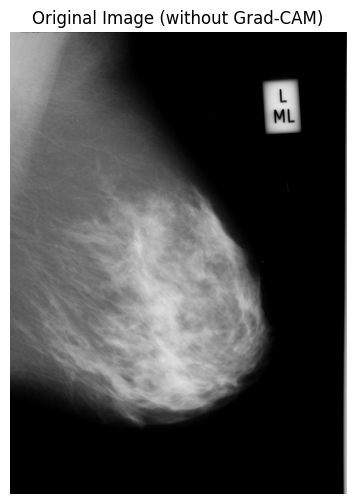

In [2]:
# Allow user to input their own Google Drive image URL or use a default one
url = input("Enter a Google Drive direct download link for an image, or press enter to use the default: ")
if not url:
    url = 'https://drive.google.com/uc?export=download&id=1owN9ljjHQRYv_UQQTCVPdwke_zP_Zg0q'

# Download the image
response = requests.get(url)
img = Image.open(BytesIO(response.content))

# Convert the image to RGB format (in case it's grayscale)
img = img.convert('RGB')
img = np.array(img)

# Display the original image
plt.figure(figsize=(6, 6))
plt.imshow(img)
plt.title("Original Image (without Grad-CAM)")
plt.axis('off')
plt.show()

## Preprocess the Image for the Model

Now, we will preprocess the image to make it compatible with the ResNet50 model.


In [3]:
# Preprocess the image for the model
img_size = (224, 224)
img_resized = cv2.resize(img, img_size)
img_array = np.expand_dims(img_resized, axis=0)
img_array = tf.keras.applications.resnet50.preprocess_input(img_array)

## Loading the ResNet50 Model

We will load a pre-trained ResNet50 model from TensorFlow's applications, which is trained on the ImageNet dataset.


In [4]:
# Load a pre-trained ResNet50 model
model = tf.keras.applications.ResNet50(weights='imagenet', include_top=True)

# Get the output of the last convolutional layer
last_conv_layer = model.get_layer('conv5_block3_out')

# Create a model that maps the input image to the activations of the last conv layer
grad_model = tf.keras.models.Model(
    [model.inputs], 
    [last_conv_layer.output, model.output]
)

## Generating the Grad-CAM Heatmap

We will now generate the Grad-CAM heatmap, which highlights the regions in the image that are most important for the model's decision.

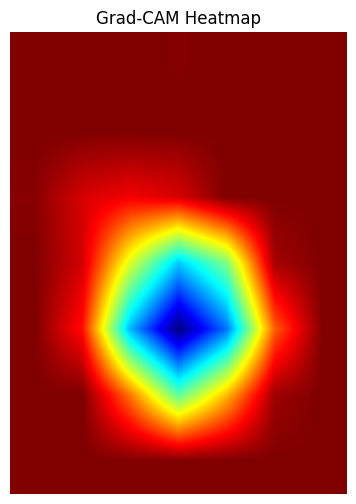

In [5]:
# Get the gradient of the top predicted class for the input image
with tf.GradientTape() as tape:
    conv_outputs, predictions = grad_model(img_array)
    top_pred_index = tf.argmax(predictions[0])
    top_class_channel = predictions[:, top_pred_index]

# Compute the gradient of the top class with regard to the output feature map
grads = tape.gradient(top_class_channel, conv_outputs)

# Compute the mean intensity of the gradient over each feature map channel
pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

# Multiply each channel in the feature map array by its corresponding gradients
conv_outputs = conv_outputs[0]
heatmap = tf.reduce_mean(tf.multiply(pooled_grads, conv_outputs), axis=-1)

# Normalize the heatmap to a range of 0 to 1
heatmap = np.maximum(heatmap, 0) / np.max(heatmap)
heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))

# Convert the heatmap to RGB
heatmap = np.uint8(255 * heatmap)
heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)

# Display the heatmap
plt.figure(figsize=(6, 6))
plt.imshow(heatmap)
plt.title("Grad-CAM Heatmap")
plt.axis('off')
plt.show()

## Superimposing Heatmap on Original Image

Finally, we will superimpose the Grad-CAM heatmap on the original image to visualize the areas of the image that were most influential in the model's prediction.


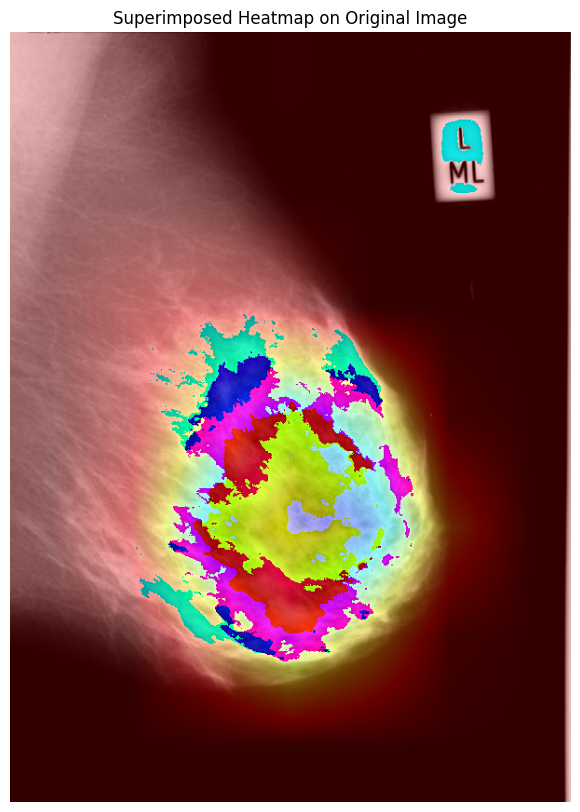

In [6]:
# Superimpose the heatmap on the original image
superimposed_img = heatmap * 0.4 + img

# Display the superimposed image
plt.figure(figsize=(10, 10))
plt.imshow(superimposed_img.astype(np.uint8))
plt.title("Superimposed Heatmap on Original Image")
plt.axis('off')
plt.show()